In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
# Importing training data

train_data1 = np.load('../DL-Project/data0.npy')
train_lab1 = np.load('../DL-Project/lab0.npy')

train_data2 = np.load('../DL-Project/data1.npy')
train_lab2 = np.load('../DL-Project/lab1.npy')

train_data3 = np.load('../DL-Project/data2.npy')
train_lab3 = np.load('../DL-Project/lab2.npy')

In [3]:
# Loading and preprocessing - normalizing the image and adding new dimension for convolutions

images = np.concatenate((train_data1, train_data2, train_data3)) / 255
labels = np.concatenate((train_lab1, train_lab2, train_lab3))

images = images[:, np.newaxis, :, :]

In [4]:
# Splitting the dataset into train, validate and test sets

train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=100
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=100
)

In [5]:
# Converting the sets to pytorch compatible tensors

train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.long)

In [6]:
# Creating the Datasets from the tensors

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = ImageDataset(train_images, train_labels)
val_dataset = ImageDataset(val_images, val_labels)
test_dataset = ImageDataset(test_images, test_labels)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# Load Pretrained ResNet-18
model = resnet18(weights=ResNet18_Weights.DEFAULT)

In [8]:
# Modify First Convolution Layer (ResNet expects 3 channels, but we have 1)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify Fully Connected Layer for 41 classes (sums from 0-40)
num_ftrs = model.fc.in_features  # Get input features of last layer
model.fc = nn.Linear(num_ftrs, 41)  # Output layer with 41 classes

print(model)  # Check the model architecture

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [10]:
# Choosing Cross Entropy loss for classification and the Adam optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Defining the Training loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()  # Set to training mode
        train_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU

            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            train_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        val_accuracy, val_loss = evaluate_model(model, val_loader)

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses

In [12]:
# Function to evaluate model accuracy

def evaluate_model(model, data_loader):
    model.eval()  # Set to evaluation mode
    correct, total = 0, 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)  # Get predicted class

            correct += (predicted_classes == labels).sum().item()
            total += labels.size(0)

    return (100 * correct / total, total_loss)  # Return accuracy percentage


In [13]:
# Training for initial 15 epochs

tl, vl = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)

Epoch 1/15 | Loss: 2.5710 | Train Acc: 13.86% | Val Acc: 16.73%
Epoch 2/15 | Loss: 2.1124 | Train Acc: 21.57% | Val Acc: 27.93%
Epoch 3/15 | Loss: 1.8264 | Train Acc: 28.62% | Val Acc: 32.83%
Epoch 4/15 | Loss: 1.5640 | Train Acc: 36.98% | Val Acc: 28.10%
Epoch 5/15 | Loss: 1.2773 | Train Acc: 48.74% | Val Acc: 53.23%
Epoch 6/15 | Loss: 1.0188 | Train Acc: 59.75% | Val Acc: 67.63%
Epoch 7/15 | Loss: 0.8535 | Train Acc: 67.67% | Val Acc: 69.90%
Epoch 8/15 | Loss: 0.6943 | Train Acc: 74.82% | Val Acc: 79.40%
Epoch 9/15 | Loss: 0.5687 | Train Acc: 79.27% | Val Acc: 78.60%
Epoch 10/15 | Loss: 0.4771 | Train Acc: 83.34% | Val Acc: 87.93%
Epoch 11/15 | Loss: 0.4289 | Train Acc: 85.21% | Val Acc: 85.93%
Epoch 12/15 | Loss: 0.3678 | Train Acc: 87.38% | Val Acc: 87.00%
Epoch 13/15 | Loss: 0.3163 | Train Acc: 89.29% | Val Acc: 86.17%
Epoch 14/15 | Loss: 0.3443 | Train Acc: 88.28% | Val Acc: 89.00%
Epoch 15/15 | Loss: 0.2751 | Train Acc: 91.10% | Val Acc: 87.90%


In [14]:
acc = evaluate_model(model, test_loader)

In [15]:
# Accuracy after 15 epochs
print(acc)

(88.13333333333334, 41.391801819205284)


In [16]:
# Save model
torch.save(model.state_dict(), "model.pth")

In [17]:
# Training for 25 more epochs

tl2, vl2 = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)
tl.extend(tl2)
vl.extend(vl2)

Epoch 1/25 | Loss: 0.2398 | Train Acc: 92.27% | Val Acc: 91.60%
Epoch 2/25 | Loss: 0.2385 | Train Acc: 92.43% | Val Acc: 93.07%
Epoch 3/25 | Loss: 0.2208 | Train Acc: 92.68% | Val Acc: 91.67%
Epoch 4/25 | Loss: 0.1993 | Train Acc: 93.41% | Val Acc: 93.20%
Epoch 5/25 | Loss: 0.2187 | Train Acc: 92.87% | Val Acc: 91.03%
Epoch 6/25 | Loss: 0.1694 | Train Acc: 94.68% | Val Acc: 90.83%
Epoch 7/25 | Loss: 0.2022 | Train Acc: 93.40% | Val Acc: 92.33%
Epoch 8/25 | Loss: 0.1601 | Train Acc: 94.70% | Val Acc: 90.27%
Epoch 9/25 | Loss: 0.1664 | Train Acc: 94.64% | Val Acc: 92.17%
Epoch 10/25 | Loss: 0.1686 | Train Acc: 94.45% | Val Acc: 92.27%
Epoch 11/25 | Loss: 0.1502 | Train Acc: 94.98% | Val Acc: 90.10%
Epoch 12/25 | Loss: 0.1500 | Train Acc: 95.21% | Val Acc: 92.63%
Epoch 13/25 | Loss: 0.1497 | Train Acc: 95.38% | Val Acc: 94.40%
Epoch 14/25 | Loss: 0.1255 | Train Acc: 95.98% | Val Acc: 91.90%
Epoch 15/25 | Loss: 0.0994 | Train Acc: 96.85% | Val Acc: 94.30%
Epoch 16/25 | Loss: 0.1634 | Train

In [18]:
acc = evaluate_model(model, test_loader)

In [19]:
print(acc)

(95.7, 23.789783879183233)


In [20]:
# Saving final model

torch.save(model.state_dict(), "model.pth")

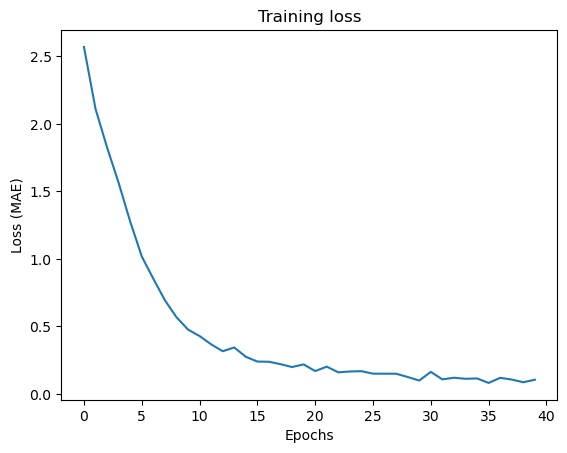

In [21]:
plt.plot(tl)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Training loss")
plt.show()

### Correction - Above and below graph denote Cross Entropy losses NOT mean absolute error

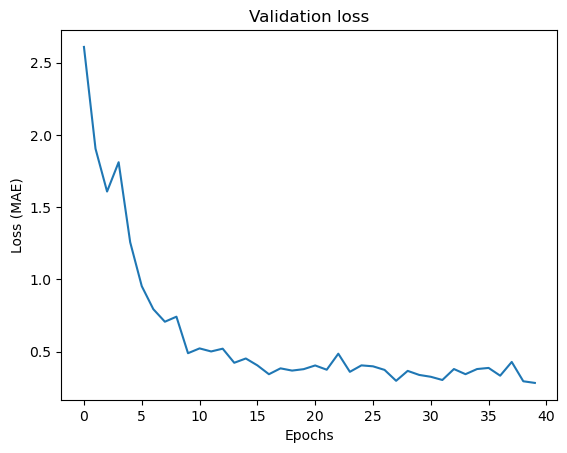

In [22]:
plt.plot(vl)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Validation loss")
plt.show()

In [23]:
# Function to evaluate L1 loss of model, to compare with baseline CNN 

criterion = nn.L1Loss()

def evaluate_l1(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            outputs = torch.argmax(model(images), dim=1)
            loss = criterion(outputs, labels.to(torch.float32))
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

In [24]:
# L1 loss of the model on test set

evaluate_l1(model, test_loader)

Test Loss: 0.0965
